# <center> Практика. Статистические тесты в контексте EDA

## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

Необходимо выяснить, какие факторы влияют на зарплату специалиста Data Scientist.

А также ответить на ключевые вопросы HR-агентства:
- Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
- Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
- Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
- Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

Данные содержат следующие столбцы:
*   *work_year* — Год, в котором была выплачена зарплата;
*   *experience_level* — Опыт работы на этой должности в течение года;
*   *employment_type* — Тип трудоустройства для этой роли;
*   *job_title* — Роль, в которой соискатель работал в течение года;
*   *salary* — Общая выплаченная валовая сумма заработной платы;
*   *salary_currency* — Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217;
*   *salary_in_usd* — Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com);
*   *employee_residence* — Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166;
*   *remote_ratio* — Общий объём работы, выполняемой удалённо;
*   *company_location* — Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166;
*   *company_size* — Среднее количество людей, работавших в компании в течение года.

Источник датасета: ["Data Science Job Salaries” (kaggle.com)](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries)

## Загрузка данных

In [2]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms
import statistics

import matplotlib.pyplot as plt
import seaborn as sns

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

In [3]:
# загружаем датасет
data = pd.read_csv('data/ds_salaries.csv')
data.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [4]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## Описательный анализ данных

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


Проверим данные на наличие полных дубликатов:

In [6]:
print('Количество полных дубликатов: {}'.format(data[data.duplicated()].shape[0]))

Количество полных дубликатов: 0


Посмотрим на основные параметры числовых признаков

In [7]:
data.describe()

,Unnamed: 0,work_year,salary,salary_in_usd,remote_ratio
count,607.000000,607.000000,6.070000e+02,607.000000,607.00000
mean,303.000000,2021.405272,3.240001e+05,112297.869852,70.92257
std,175.370085,0.692133,1.544357e+06,70957.259411,40.70913
min,0.000000,2020.000000,4.000000e+03,2859.000000,0.00000
25%,151.500000,2021.000000,7.000000e+04,62726.000000,50.00000
50%,303.000000,2022.000000,1.150000e+05,101570.000000,100.00000
75%,454.500000,2022.000000,1.650000e+05,150000.000000,100.00000
max,606.000000,2022.000000,3.040000e+07,600000.000000,100.00000


Проверим значения в столбцах *work_year* и *remote_ratio*

In [8]:
display(data['work_year'].value_counts())
display(data['remote_ratio'].value_counts())

work_year
2022    318
2021    217
2020     72
Name: count, dtype: int64

remote_ratio
100    381
0      127
50      99
Name: count, dtype: int64

* В датасете 607 записей. 
* Пропущенных значений нет, дубликаты отсутствуют.
* Поля, содержащие числовые признаки имеют корректные типы (int и float): *work_year*, *salary*, *salary_in_usd*, *remote_ratio*. 
* Категориальные признаки имеют тип object: *experience_level*, *employment_type*, *job_title*, *salary_currency*, *employee_residence*, *company_location*, *company_size*.

Предлагается исключить из анализа такие признаки как *salary* и *salary_currency*, поскольку уже есть отдельный признак *salary_in_usd*, который содержит сумму заработной платы, приведенной к одной валюте - доллары. Это видно по строкам датасета где валюта = USD, в этом случае *salary* и *salary_in_usd* содержат одинаковые значения.

Также исключим из анализа столбец *Unnamed: 0*, который содержит просто порядковые номера записей в датасете.

Кроме этого поля *work_year* и *remote_ratio* содержат всего лишь по 3 уникальных значения, поэтому предлагается их также отнести к категориальным признакам. Таким образом из числовых признаков остается только столбец *salary_in_usd* 

In [9]:
# Удаляем неинформативные признаки
data = data.drop(columns=['salary', 'salary_currency', 'Unnamed: 0'], axis=1)
data.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,US,50,US,L


Посмотрим на распределение специалистов по странам главного офиса работодателя. 

In [42]:
data['company_location'].value_counts(normalize=True)

company_location
US    0.584843
GB    0.077430
CA    0.049423
DE    0.046129
IN    0.039539
FR    0.024712
ES    0.023064
GR    0.018122
JP    0.009885
NL    0.006590
AT    0.006590
PT    0.006590
PL    0.006590
LU    0.004942
PK    0.004942
BR    0.004942
AE    0.004942
MX    0.004942
AU    0.004942
TR    0.004942
DK    0.004942
IT    0.003295
CZ    0.003295
SI    0.003295
RU    0.003295
CH    0.003295
NG    0.003295
CN    0.003295
BE    0.003295
VN    0.001647
EE    0.001647
AS    0.001647
DZ    0.001647
MY    0.001647
MD    0.001647
KE    0.001647
SG    0.001647
CO    0.001647
IR    0.001647
CL    0.001647
MT    0.001647
IL    0.001647
UA    0.001647
IQ    0.001647
RO    0.001647
HR    0.001647
NZ    0.001647
HU    0.001647
HN    0.001647
IE    0.001647
Name: proportion, dtype: float64

Наибольшее количество специалистов (более 58%) работает на компании, главные офисы которых находятся в США. 

Добавим в датасет дополнительное поле *is_US*, который покажет признак нахождения главного офиса работодателя в США.

In [44]:
data['is_US'] = data['company_location'].apply(lambda x: 1 if x=='US' else 0)
data.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,is_US
0,2020,MI,FT,Data Scientist,79833,DE,0,DE,L,0
1,2020,SE,FT,Machine Learning Scientist,260000,JP,0,JP,S,0
2,2020,SE,FT,Big Data Engineer,109024,GB,50,GB,M,0
3,2020,MI,FT,Product Data Analyst,20000,HN,0,HN,S,0
4,2020,SE,FT,Machine Learning Engineer,150000,US,50,US,L,1


Проверим основные статистические показатели единственного числового признака *salary_in_usd*. 

In [10]:
print("Среднее значение = {:.2f}".format(statistics.mean(data['salary_in_usd'])))
print("Медиана = {:.2f}".format(statistics.median(data['salary_in_usd'])))
print("Мода = {:.2f}".format(statistics.mode(data['salary_in_usd'])))


Среднее значение = 112297.87
Медиана = 101570.00
Мода = 100000.00


## Разведывательный анализ данных

Проверим единственный числовой признак на нормальность используя визуализацию.

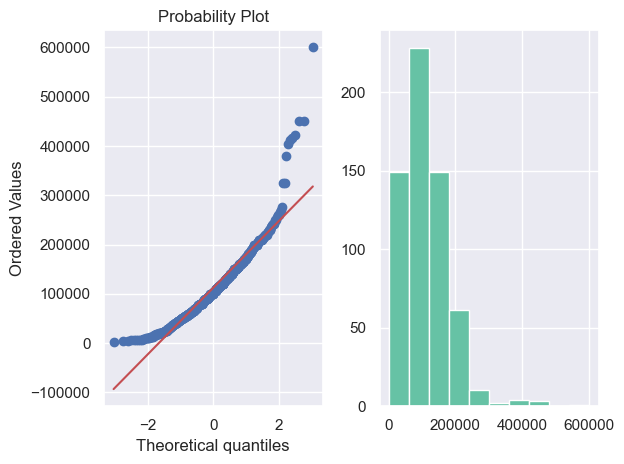

In [11]:
import matplotlib.pyplot as plt # библиотека визуализации
from scipy import stats # библиотека для расчетов

plt.subplot(1, 2, 1) # задаем сетку рисунка количество строк и столбцов
stats.probplot(data['salary_in_usd'], plot=plt) # qq plot

plt.subplot(1, 2, 2) # располагаем второй рисунок рядом
plt.hist(data['salary_in_usd']) # гистограмма распределения признака

plt.tight_layout() # чтобы графики не наезжали другу на друга, используем tight_layout

plt.show() # просмотр графика

Из визуализации видно, что признак распределён ненормально, так как q-q plot имеет изогнутую линию с выбросами в верхней части, а гистограмма распределения похожа на смещенный колокол.

На всякий случай проверим корреляцию между имеющимися числовыми признаками. Из этого анализа будет видно, что корреляция между признаками низкая.

<Axes: >

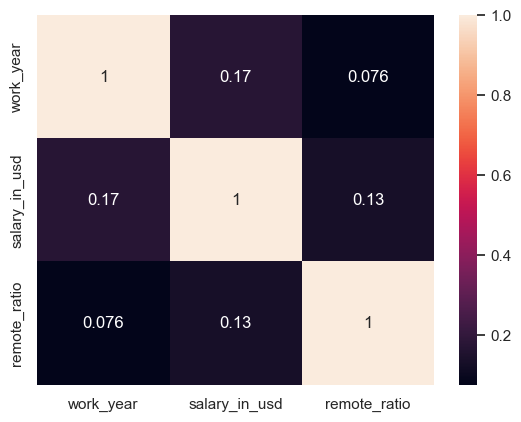

In [12]:
import seaborn as sns
sns.heatmap(data.corr(numeric_only=True), annot=True)

### Распределение заработной платы по всему рынку

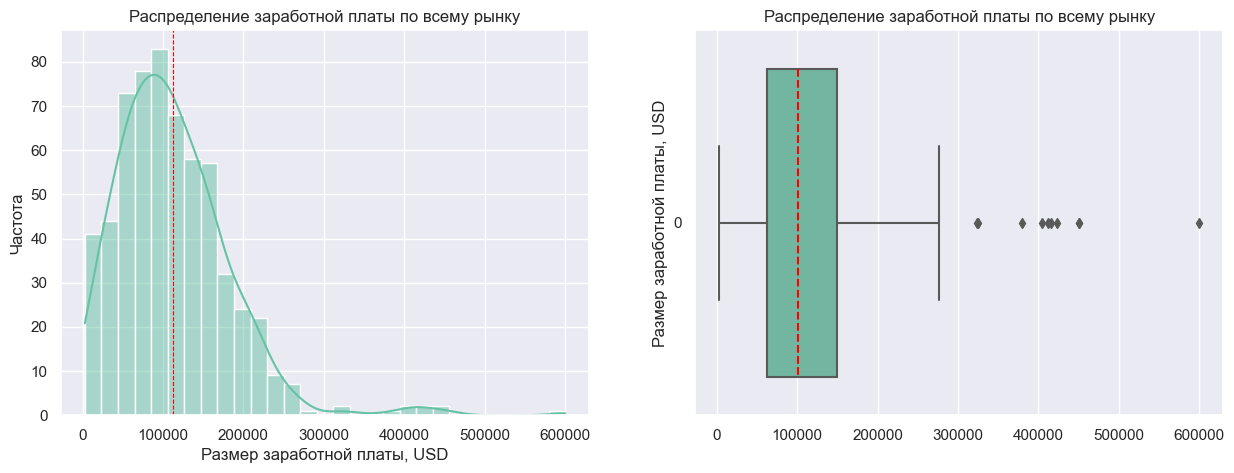

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер заработной платы, USD', ylabel='Частота')
axes[0].set_title('Распределение заработной платы по всему рынку')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Размер заработной платы, USD')
axes[1].set_title('Распределение заработной платы по всему рынку')

plt.show()

In [14]:
data_agg = data['salary_in_usd'].describe().round(2).to_frame()
data_agg.columns = ['Размер заработной платы, USD']
data_agg

,"Размер заработной платы, USD"
count,607.00
mean,112297.87
std,70957.26
min,2859.00
25%,62726.00
50%,101570.00
75%,150000.00
max,600000.00


Распределение заработной платы отлично от нормального, имеются выбросы.

### Заработная плата специалистов Data Scientist по годам

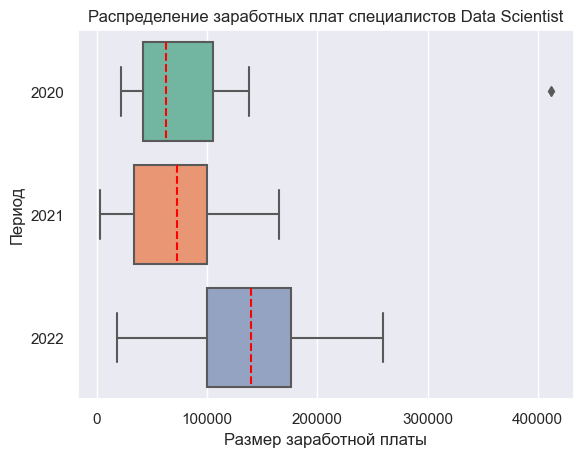

In [15]:
ax = sns.boxplot(data[data['job_title']=='Data Scientist'], x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер заработной платы', ylabel='Период')
plt.title('Распределение заработных плат специалистов Data Scientist')
plt.show()

In [16]:
data_agg = data[data['job_title']=='Data Scientist'].groupby('work_year')['salary_in_usd'].describe().round(2)
print('Распределение заработных плат специалистов Data Scientist по годам')
data_agg

Распределение заработных плат специалистов Data Scientist по годам


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,21.0,85970.52,81436.65,21669.0,42197.0,62726.0,105000.0,412000.0
2021,45.0,70671.73,45422.97,2859.0,33808.0,73000.0,100000.0,165000.0
2022,77.0,136172.09,54563.08,18442.0,100000.0,140000.0,176000.0,260000.0


Заметен рост размера заработных плат специалистов Data Scientist с течением времени. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистическое тестирование.

### Соотношение зарплат Data Scientist и Data Engineer в 2022 году

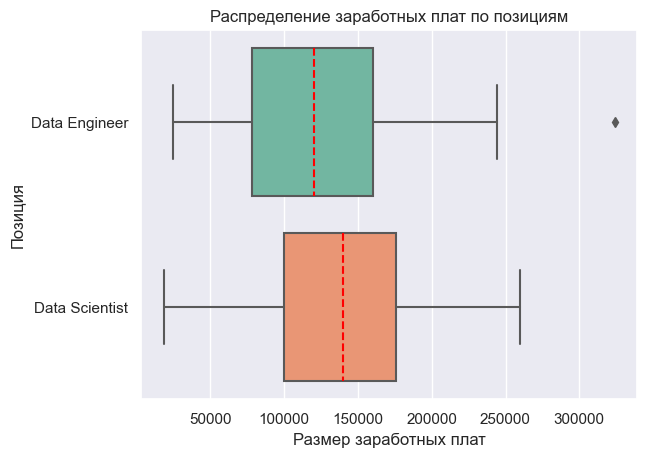

In [17]:
mask1 = data['job_title']=='Data Scientist'
mask2 = data['job_title']=='Data Engineer'
mask3 = data['work_year'] == 2022

ax = sns.boxplot(data[(mask1 | mask2) & mask3], x='salary_in_usd', y='job_title', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер заработных плат', ylabel='Позиция')
plt.title('Распределение заработных плат по позициям')
plt.show()

In [18]:
data_agg = data[(mask1 | mask2) & mask3].groupby('job_title')['salary_in_usd'].describe().round(2)
print('Зарплата в зависимости от позиции')
data_agg

Зарплата в зависимости от позиции


,count,mean,std,min,25%,50%,75%,max
job_title,,,,,,,,
Data Engineer,89.0,126375.70,55954.40,25000.0,78526.0,120000.0,160000.0,324000.0
Data Scientist,77.0,136172.09,54563.08,18442.0,100000.0,140000.0,176000.0,260000.0


По графику на первый взгляд видно, что зарплаты у Data Scientist выше, чем у Data Engineer. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

### Зарплаты Data Scientist в зависимости от размера компании

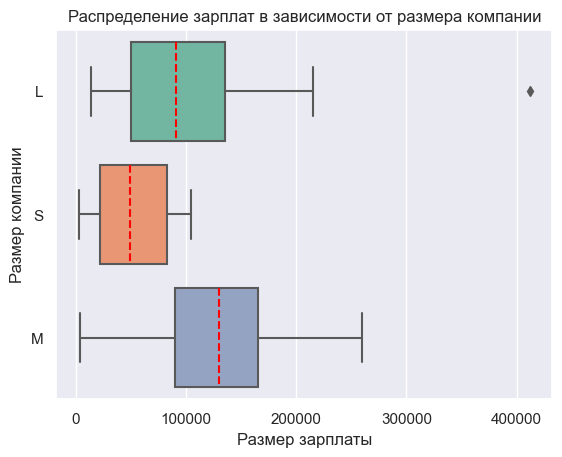

In [19]:
ax = sns.boxplot(data[data['job_title']=='Data Scientist'], x='salary_in_usd', y='company_size', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплаты', ylabel='Размер компании')
plt.title('Распределение зарплат в зависимости от размера компании')
plt.show()

In [20]:
data_agg = data[data['job_title']=='Data Scientist'].groupby('company_size')['salary_in_usd'].describe().round(2)
print('Распределение зарплат в зависимости от размера компании')
data_agg

Распределение зарплат в зависимости от размера компании


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,45.0,103313.36,71815.18,13400.0,50000.0,90734.0,135000.0,412000.0
M,77.0,126380.75,56389.53,4000.0,90000.0,130000.0,165000.0,260000.0
S,21.0,51925.76,33216.29,2859.0,21669.0,49268.0,82500.0,105000.0


Распределение зарплат различно для разных размеров компаний, причем нет прямой связи, что чем крупнее компания, тем больше заработная плата, т.к. на графике виден приоритет средних компаний (М). Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

### Соотношение позиций Data Scientist и Data Engineer в компаниях различного размера

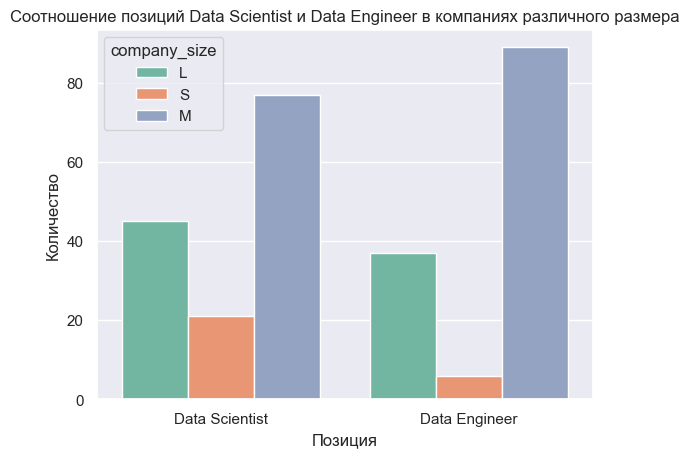

In [21]:
ax = sns.countplot(data=data[mask1 | mask2], x=data[mask1 | mask2]['job_title'], hue='company_size')
ax.set(xlabel='Позиция', ylabel='Количество')
plt.title('Соотношение позиций Data Scientist и Data Engineer в компаниях различного размера')
plt.show()

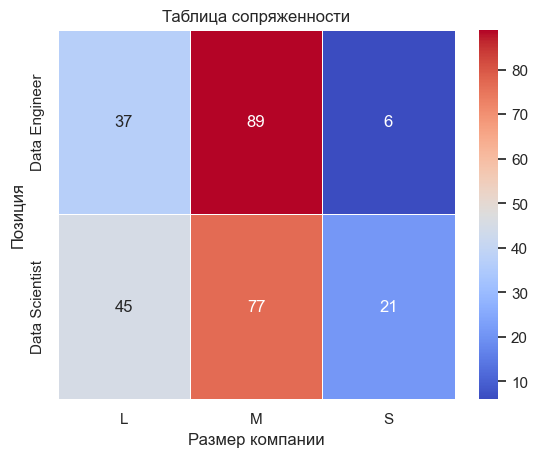

In [22]:
cross_tab = pd.crosstab(index=data[mask1 | mask2]['job_title'], columns=data[mask1 | mask2]['company_size'])
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm")
ax.set(xlabel='Размер компании', ylabel='Позиция')
plt.title('Таблица сопряженности')
plt.show()

Согласно данным, наибольшее количество позиций Data Scientist и Data Engineer открыто в компаниях среднего размера. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

### Зависимость заработных плат специалистов Data Scientist от опыта работы

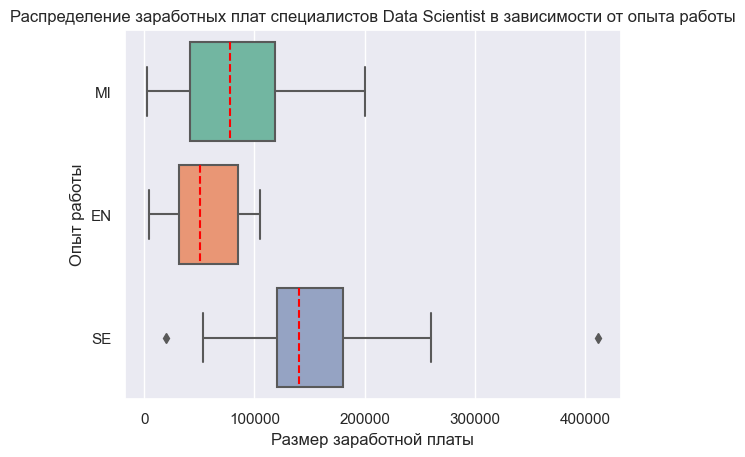

In [48]:
ax = sns.boxplot(data[data['job_title']=='Data Scientist'], x='salary_in_usd', y='experience_level', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер заработной платы', ylabel='Опыт работы')
plt.title('Распределение заработных плат специалистов Data Scientist в зависимости от опыта работы')
plt.show()

In [49]:
data_agg = data[data['job_title']=='Data Scientist'].groupby('experience_level')['salary_in_usd'].describe().round(2)
print('Распределение заработных плат специалистов Data Scientist в зависимости от опыта работы')
data_agg

Распределение заработных плат специалистов Data Scientist в зависимости от опыта работы


,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,22.0,55330.91,31237.82,4000.0,31474.0,50483.5,85027.25,105000.0
MI,60.0,82039.13,46869.58,2859.0,41768.0,77479.0,118264.75,200000.0
SE,61.0,152971.02,58985.40,20171.0,120000.0,140400.0,180000.00,412000.0


Согласно полученным данным, опыт работы имеет влияние на уровень заработной платы. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

### Зависимость зарплаты Data Scientist от нахождения главного офиса работодателя в США

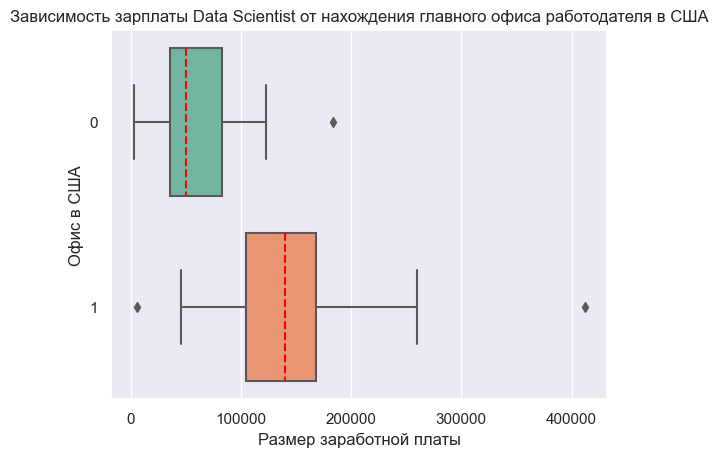

In [51]:
ax = sns.boxplot(data[data['job_title']=='Data Scientist'], x='salary_in_usd', y='is_US', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер заработной платы', ylabel='Офис в США')
plt.title('Зависимость зарплаты Data Scientist от нахождения главного офиса работодателя в США')
plt.show()

In [52]:
data_agg = data[data['job_title']=='Data Scientist'].groupby('is_US')['salary_in_usd'].describe().round(2)
print('Зависимость зарплаты Data Scientist от нахождения главного офиса работодателя в США')
data_agg

Зависимость зарплаты Data Scientist от нахождения главного офиса работодателя в США


,count,mean,std,min,25%,50%,75%,max
is_US,,,,,,,,
0,59.0,58460.05,35395.62,2859.0,35662.5,50000.0,83268.0,183228.0
1,84.0,143115.68,56252.98,5679.0,105000.0,140000.0,167750.0,412000.0


Исходя из полученной диаграммы, работодатели из США платят существенно большую заработную плату. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

## Статистический анализ данных



In [25]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

### Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер заработной платы в 2020 году ($μ_1$) статистически больше либо равен размеру заработной платы в 2021 году ($μ_2$) и статистически больше или равен размеру заработной платы в 2022 году ($μ_3$)

$$ H_0 : μ_1 >= μ_2 >= μ_3$$

*Альтернативная гипотеза* ($H_1$): размер заработной платы в 2020 году ($μ_1$) статистически меньше, чем размер заработной платы в 2021 году ($μ_2$) и статистически меньше, чем размер заработной платы в 2022 году ($μ_3$).

$$ H_1 : μ_1 < μ_2 < μ_3$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. 

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [26]:
# значения заработных плат специалистов Data Scientist по годам
salary_20 = data.loc[(data['job_title']=='Data Scientist') & (data['work_year']==2020), 'salary_in_usd']
salary_21 = data.loc[(data['job_title']=='Data Scientist') & (data['work_year']==2021), 'salary_in_usd']
salary_22 = data.loc[(data['job_title']=='Data Scientist') & (data['work_year']==2022), 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для 2020 года:')
result = stats.shapiro(salary_20)
decision_normality(result[1])

print('Для 2021 года:')
result = stats.shapiro(salary_21)
decision_normality(result[1])

print('Для 2022 года:')
result = stats.shapiro(salary_22)
decision_normality(result[1])

Для 2020 года:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 2021 года:
p-value = 0.125
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для 2022 года:
p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер заработной платы»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет (т.к. признак за 20 год не распределен нормально).

Чтобы проверить нашу гипотезу, можно использовать Критерий Краскера - Уоллиса.

**Проведём тест**

In [27]:
# проводим тест
_, p = stats.kruskal(salary_20, salary_21, salary_22)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Предварительный вывод**

Метод Краскера - Уоллиса показал, что все три признака статистически отличаются (в части сравнения их медиан), но к сожалению не дает оснований положительно ответить на исследуемый вопрос. Для этого необходимо дополнительно попарно сравнить 20 год с 21, и 21 с 22.

**Выдвигаем подгипотезу 1**

*Нулевая гипотеза* ($H_0$): размер заработной платы в 2020 году ($μ_1$) статистически больше либо равен размеру заработной платы в 2021 году ($μ_2$).

$$ H_0 : μ_1 >= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер заработной платы в 2020 году ($μ_1$) статистически меньше, чем размер заработной платы в 2021 году ($μ_2$).

$$ H_1 : μ_1 < μ_2$$

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер заработной платы»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет (т.к. признак за 20 год не распределен нормально).

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна-Уитни.

In [28]:
# проводим тест
_, p = stats.mannwhitneyu(salary_20, salary_21, alternative='less')
decision_hypothesis(p)

p-value = 0.685
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Выдвигаем подгипотезу 2**

*Нулевая гипотеза* ($H_0$): размер заработной платы в 2021 году ($μ_2$) статистически больше либо равен размеру заработной платы в 2022 году ($μ_3$).

$$ H_0 : μ_2 >= μ_3$$

*Альтернативная гипотеза* ($H_1$): размер заработной платы в 2021 году ($μ_2$) статистически меньше, чем размер заработной платы в 2022 году ($μ_3$).

$$ H_1 : μ_2 < μ_3$$

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер заработной платы»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да (признаки за 21 и 22 года распределены нормально).

Чтобы проверить нашу гипотезу, можно использовать двухвыборочный Т-критерий.

In [29]:
# проводим тест Левена на равенство дисперсий
print('Тест на равенство дисперсий')
result = stats.levene(salary_21, salary_22)
p = result[1]
print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

Тест на равенство дисперсий
p-value = 0.445
Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.


In [30]:
# проводим тест на сравнение средних в группах
print('\nТест на равенство средних')
_, p = stats.ttest_ind(salary_21, salary_22, alternative='less', equal_var=True)
decision_hypothesis(p)



Тест на равенство средних
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Дополнительная проверка подгипотез показала следующий результат: нельзя утверждать что статистически наблюдается ежегодный рост заработной платы специалистов Data Science, если говорить про весь рассматриваемый период - с 2020 по 2022 год. Однако такой вывод можно однозначно сделать для периода с 2021 по 2022 год, где статистически наблюдается явный рост заработной платы специалистов Data Science.

### Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?


**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер заработной платы у Data Scientist ($μ_1$) статистически меньше либо равен размеру заработной платы у Data Engineer ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер заработной платы у Data Scientist ($μ_1$) статистически больше размера заработной платы у Data Engineer ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [31]:
# значения заработных плат специалистов Data Scientist по годам
salary_DS = data.loc[(data['job_title']=='Data Scientist') & (data['work_year']==2022), 'salary_in_usd']
salary_DE = data.loc[(data['job_title']=='Data Engineer') & (data['work_year']==2022), 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для Data Scientist:')
result = stats.shapiro(salary_DS)
decision_normality(result[1])

print('Для Data Engineer:')
result = stats.shapiro(salary_DE)
decision_normality(result[1])

Для Data Scientist:
p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для Data Engineer:
p-value = 0.010
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер заработной платы»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

**Проведём тест**


In [32]:
# проводим тест
_, p = stats.mannwhitneyu(salary_DS, salary_DE, alternative='greater')
decision_hypothesis(p)

p-value = 0.077
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Отличия в размере заработных плат у специалистов Data Scientist и Data Engineer в 2022 году не являются статистически значимыми. Т.е. статистически в 2022 году уровень зарплаты не зависел от должности.

### Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер зарплат у Data Scientist не отличается в компаниях различного размера:  S ($μ_1$), M ($μ_2$), L ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза*: размер зарплат у Data Scientist отличается в компаниях различного размера:  S ($μ_1$), M ($μ_2$), L ($μ_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [33]:
# значения 
salary_S = data.loc[(data['job_title']=='Data Scientist') & (data['company_size']=='S'), 'salary_in_usd']
salary_M = data.loc[(data['job_title']=='Data Scientist') & (data['company_size']=='M'), 'salary_in_usd']
salary_L = data.loc[(data['job_title']=='Data Scientist') & (data['company_size']=='L'), 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для S-компаний:')
result = stats.shapiro(salary_S)
decision_normality(result[1])

print('Для M-компаний:')
result = stats.shapiro(salary_M)
decision_normality(result[1])

print('Для L-компаний:')
result = stats.shapiro(salary_L)
decision_normality(result[1])


Для S-компаний:
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для M-компаний:
p-value = 0.639
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для L-компаний:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер заработной платы»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [34]:
# проводим тест
_, p = stats.kruskal(salary_S, salary_M, salary_L)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Уровень заработной платы специалистов Data Science зависит от размера компании.

### Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: между наличием должностей Data Scientist и Data Engineer и размером компании нет взаимосвязи (признаки независимы).

*Альтернативная гипотеза*: между наличием должностей Data Scientist и Data Engineer и размером компании есть взаимосвязь (признаки зависимы).


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер компании»? — Категориальный.
* Сколько сравниваемых групп? — Две.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [36]:
# составляем таблицу сопряжённости
cross_table = pd.crosstab(data[mask1 | mask2]['job_title'], data[mask1 | mask2]['company_size'])

cross_table

company_size,L,M,S
job_title,,,
Data Engineer,37,89,6
Data Scientist,45,77,21


In [37]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

p-value = 0.008
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Существует статистически значимая взаимосвязь между наличием должностей Data Scientist и Data Engineer и размером компани

### Влияет ли опыт работы на размер заработной платы Data Scientist?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер зарплат у Data Scientist не отличается в зависимости от опыта работы:  EN ($μ_1$), MI ($μ_2$), SE ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза*: размер зарплат у Data Scientist отличается в зависимости от опыта работы:  EN ($μ_1$), MI ($μ_2$), SE ($μ_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [53]:
# значения 
salary_EN = data.loc[(data['job_title']=='Data Scientist') & (data['experience_level']=='EN'), 'salary_in_usd']
salary_MI = data.loc[(data['job_title']=='Data Scientist') & (data['experience_level']=='MI'), 'salary_in_usd']
salary_SE = data.loc[(data['job_title']=='Data Scientist') & (data['experience_level']=='SE'), 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для Entry-level:')
result = stats.shapiro(salary_EN)
decision_normality(result[1])

print('Для Mid-level:')
result = stats.shapiro(salary_MI)
decision_normality(result[1])

print('Для Senior-level:')
result = stats.shapiro(salary_SE)
decision_normality(result[1])


Для Entry-level:
p-value = 0.174
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для Mid-level:
p-value = 0.178
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для Senior-level:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер заработной платы»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [54]:
# проводим тест
_, p = stats.kruskal(salary_EN, salary_MI, salary_SE)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Уровень заработной платы специалистов Data Science зависит от опыта работы.

### Являются ли работодатели из США более щедрыми? 

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер зарплат у работодателей из США ($μ_1$) не больше чем у работодателей из других стран ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза*: размер зарплат у работодателей из США ($μ_1$) больше чем у работодателей из других стран ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [55]:
# значения 
salary_is_US = data.loc[(data['job_title']=='Data Scientist') & (data['is_US']==1), 'salary_in_usd']
salary_not_US = data.loc[(data['job_title']=='Data Scientist') & (data['is_US']==0), 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для работодателей из США:')
result = stats.shapiro(salary_is_US)
decision_normality(result[1])

print('Для работодателей из других стран:')
result = stats.shapiro(salary_not_US)
decision_normality(result[1])

Для работодателей из США:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для работодателей из других стран:
p-value = 0.010
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер заработной платы»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

**Проведём тест**

In [56]:
# проводим тест
_, p = stats.mannwhitneyu(salary_is_US, salary_not_US, alternative='greater')
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Работодатели из США более щедры к специалистам Data Science по сравнению с работодателями из других стран.

## Итоговые результаты исследования


* Нет оснований утверждать, что наблюдается ежегодный рост заработной платы специалистов Data Science, если говорить про весь рассматриваемый период - с 2020 по 2022 год. Однако такой вывод можно однозначно сделать для периода с 2021 по 2022 год, где статистически наблюдается явный рост заработной платы специалистов Data Science.

* Отличия в размере заработных плат у специалистов Data Scientist и Data Engineer в 2022 году не являются статистически значимыми. Т.е. статистически в 2022 году уровень зарплаты не зависел от должности.

* Уровень заработной платы специалистов Data Science зависит от размера компании.

* Существует статистически значимая взаимосвязь между наличием должностей Data Scientist и Data Engineer и размером компани.

* Уровень заработной платы специалистов Data Science зависит от опыта работы.

* Работодатели из США более щедры к специалистам Data Science по сравнению с работодателями из других стран.